In [1]:
import os
from os.path import join
from glob import glob
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import folium.plugins as plugins
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
import datetime
from datetime import timedelta
from port_call import create_port_calls
import boto3

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [2]:
ais_dir = join(os.path.expanduser("~"), 'data', 'AIS')
data_dir = join(ais_dir, 'Syria')

In [3]:
data_files = glob(data_dir+"/*.csv")

In [4]:
dfs = [pd.read_csv(f, index_col=0) for f in data_files]

In [5]:
df = pd.concat(dfs)

In [6]:
data = df.copy()
data[['Date','Time']] = data.dt_pos_utc.str.split(' ',expand=True)
data['hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S',errors = 'coerce').dt.hour
data['dtg'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.loc[data.Date<"2022-08-01"].copy()
data.drop(['Date','Time', 'hour', 'dtg'], axis=1, inplace=True)

In [7]:
df_new = pd.read_csv('s3://wbgdecinternal-ntl/Andres_Temp/AIS/AIS_Syria_2022-08-01_2023-03-20.csv', index_col=0)

In [8]:
df_turkey = pd.read_csv('s3://wbgdecinternal-ntl/Andres_Temp/AIS/AIS_Turkey_2023-01-01_2023-03-20.csv', index_col=0)

In [9]:
df_turkey2 = pd.read_csv('s3://wbgdecinternal-ntl/Andres_Temp/AIS/AIS_Isdemir_2022-08-01_2023-03-20.csv', index_col=0)

In [10]:
df = pd.concat([data, df_new])

In [11]:
len(df)

101691

In [12]:
len(df_turkey)

1269570

In [13]:
len(df_turkey2)

1719886

In [14]:
df_turkey = pd.concat([df_turkey, df_turkey2])

In [15]:
df_turkey.loc[df_turkey.polygon_name=='YAKACIK', "polygon_name"] = 'Isdemir'

In [16]:
df_turkey.loc[:, "polygon_name"] = df_turkey.polygon_name.str.capitalize()

In [17]:
df = df.loc[df.polygon_name!="BANIYAS"].copy()

In [18]:
df = pd.concat([df, df_turkey])

In [19]:
df.loc[:, "polygon_name"] = df.polygon_name.str.capitalize()

In [20]:
# df_turkey.head()

In [21]:
df = df.loc[~df.mmsi.isna()].copy()

In [22]:
df.loc[:, "mmsi"] = df.loc[:, "mmsi"].astype('int')

In [23]:
# df.loc[:, "imo"] = df.loc[:, "imo"].astype('int')

In [24]:
df[['Date','Time']] = df.dt_pos_utc.str.split(' ',expand=True)

In [25]:
df['Date'] = pd.to_datetime(df['Date'])

In [26]:
df['ym'] = df['Date'].dt.strftime('%Y-%m')

In [27]:
drop_types = ["Reserved", "Passenger"]
df = df.loc[~(df.vessel_type.isin(drop_types))].copy()

In [28]:
df = df.loc[df['Date']>="2023-01-01"].copy()

In [29]:
df_sub = df[['Date', 'polygon_name', 'mmsi']].copy()

In [30]:
df_sub.tail(2)

Date polygon_name       mmsi
1586009 2023-03-20      Isdemir  271072153
1586359 2023-03-20      Isdemir  538007475

In [31]:
df_sub = df_sub.drop_duplicates(subset=['Date', 'mmsi'])

In [32]:
df_sub = df_sub.groupby(['Date', 'polygon_name']).count()

In [33]:
# df[['Date', 'polygon_name', 'mmsi']].groupby(['Date', 'polygon_name']).unique()

In [34]:
df_sub.reset_index(inplace=True)

In [35]:
df_sub.polygon_name.unique()

array(['Isdemir', 'Iskenderun', 'Mersin', 'Tartus', 'Al ladhiqiyah'],
      dtype=object)

In [36]:
# df_temp = df_sub.loc[df_sub['Date']>"2022-01-01"]

In [37]:
df_temp = df_sub.copy()

In [47]:
# df_temp['Date'] = pd.to_datetime(df_temp['Date'])

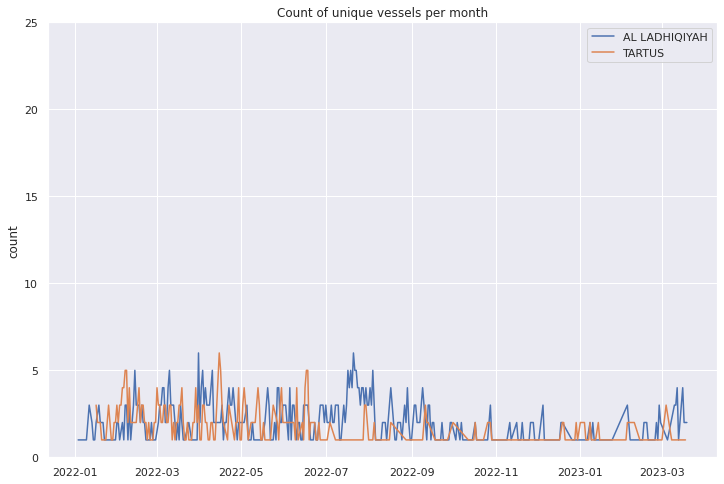

In [230]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.lineplot(
    data=df_temp,
    x='Date',
    y='mmsi',
    hue='polygon_name',
    
)

ax.set_title("Count of unique vessels per month")
ax.set_ylabel("count")
ax.set_xlabel("")
ax.set_ylim(ymin=0, ymax=25)

# plt.legend(title='Port')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
# x_dates = df_temp['Date'].dt.strftime('%Y-%m').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

In [38]:
sns.set()

In [40]:
df_temp.to_csv("Vessel Count Per Day.csv")

In [41]:
os.getcwd()

'/home/wb514197/Repos/syria-economic-monitor/notebooks/ais-analysis'

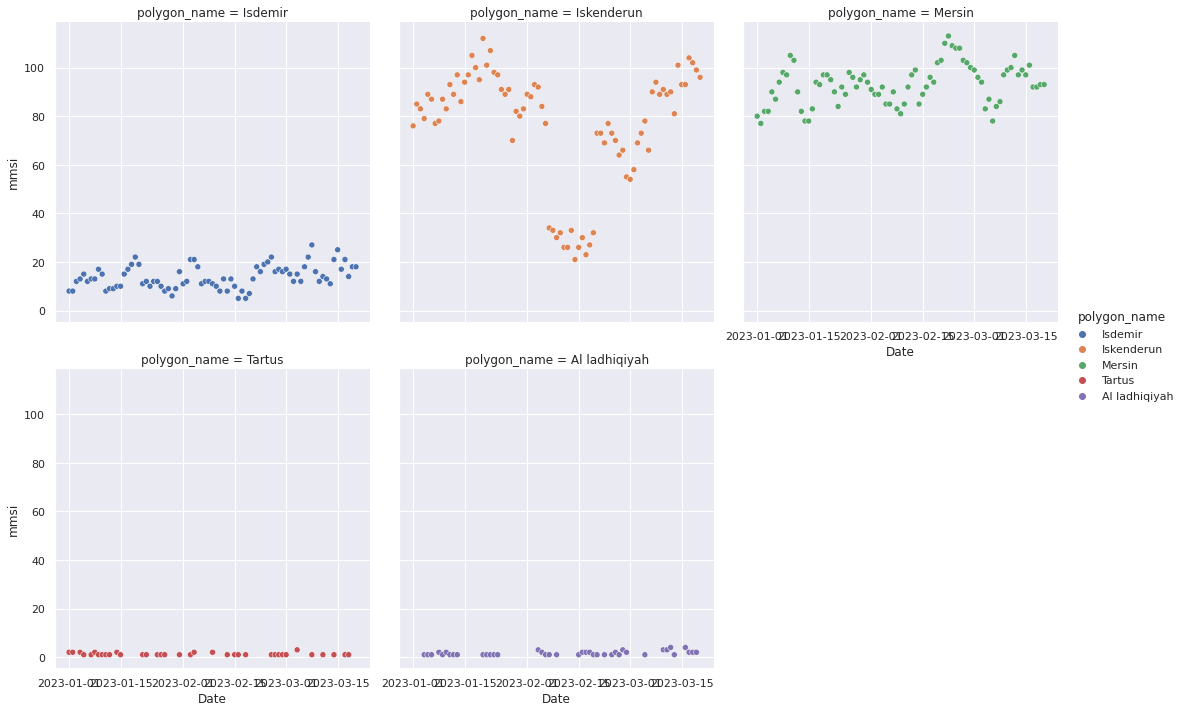

In [39]:
# fig, ax = plt.subplots(figsize=(12, 8))

sns.relplot(
    data=df_temp,
    x='Date',
    y='mmsi',
    hue='polygon_name',
    kind='scatter',
    col='polygon_name',
    col_wrap=3,
#     ncol=2
)

# x_dates = df_temp['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
# ax.set_title("Count of unique vessels per day")
# ax.set_ylabel("count")
# ax.set_xlabel("")
# ax.set_ylim(ymin=0, ymax=25)

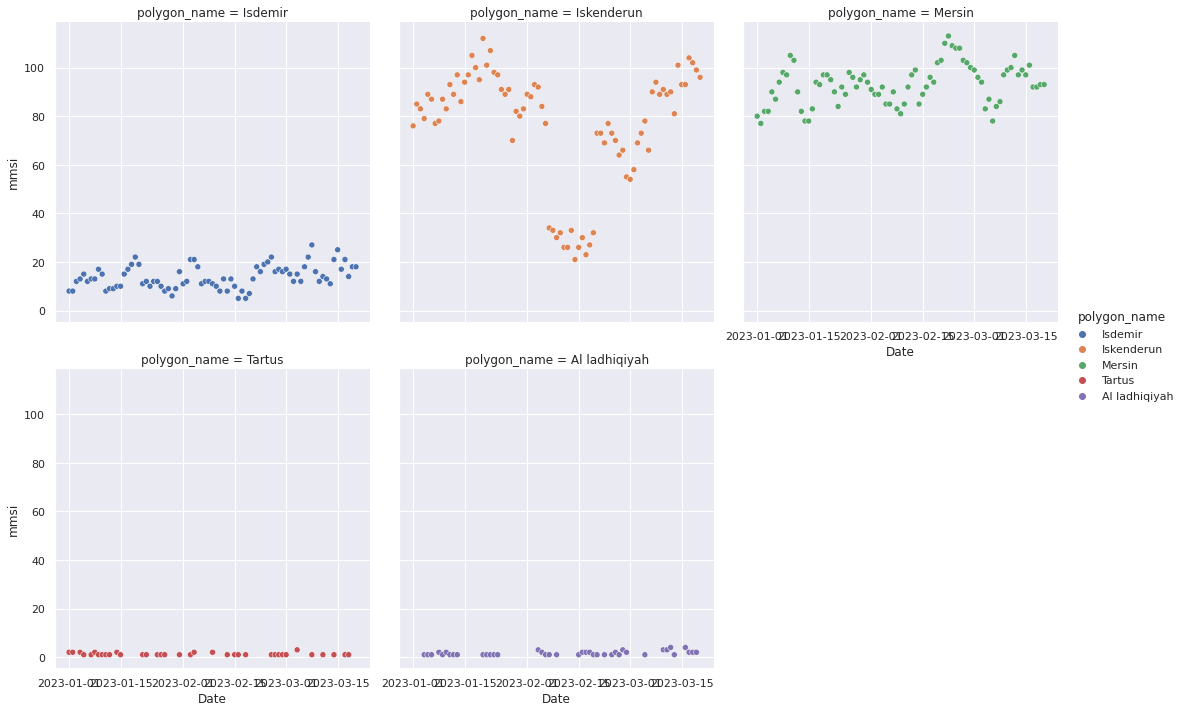

In [50]:
# fig, ax = plt.subplots(figsize=(12, 8))

sns.relplot(
    data=df_temp,
    x='Date',
    y='mmsi',
    hue='polygon_name',
    kind='scatter',
    col='polygon_name',
    col_wrap=3,
#     ncol=2
)

# x_dates = df_temp['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
# ax.set_title("Count of unique vessels per day")
# ax.set_ylabel("count")
# ax.set_xlabel("")
# ax.set_ylim(ymin=0, ymax=25)

In [43]:
import matplotlib.dates as mdates

In [56]:
g.axes[0]

<AxesSubplot:title={'center':'polygon_name = ISKENDERUN'}, xlabel='Date', ylabel='mmsi'>

In [51]:
os.getcwd()

'/home/wb514197/Repos/syria-economic-monitor/notebooks/ais-analysis'

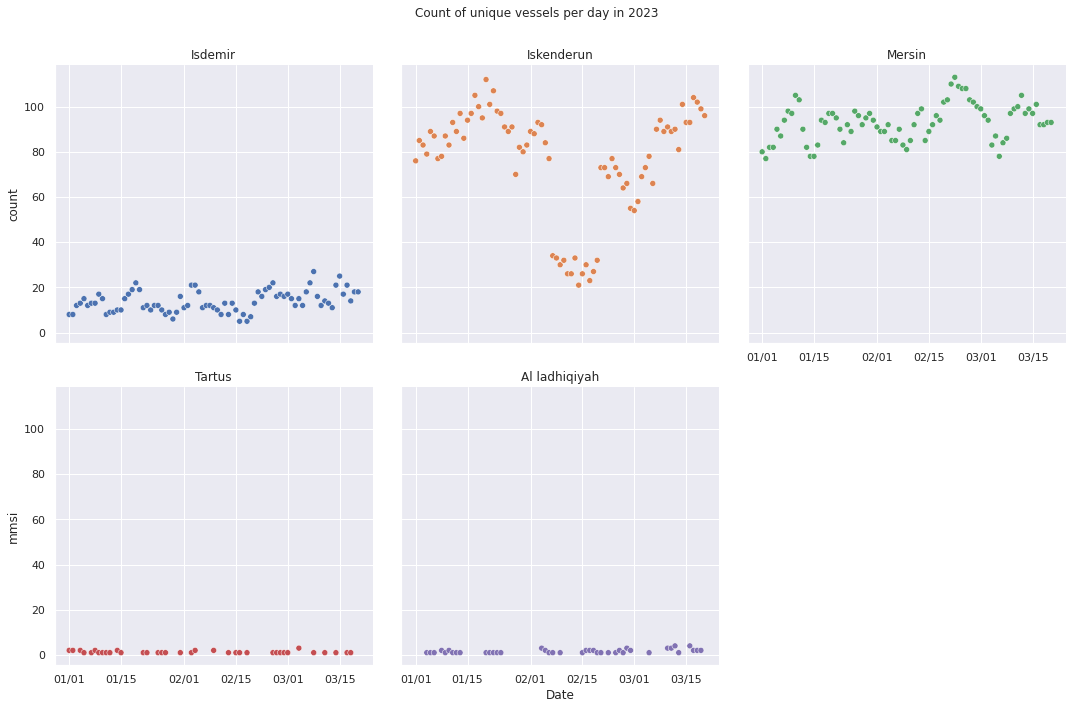

In [50]:
# fig, ax = plt.subplots(figsize=(12, 8))

g = sns.relplot(
    data=df_temp,
    x='Date',
    y='mmsi',
    hue='polygon_name',
    kind='scatter',
    col='polygon_name',
    col_wrap=3,
    legend=False
)

# dates = df_temp['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
xformatter = mdates.DateFormatter("%m/%d")
g.axes[0].xaxis.set_major_formatter(xformatter)
g.axes[0].set_ylabel("count")
g.axes[2].set_ylabel("count")
g.axes[2].set_xlabel("")
g.axes[3].set_xlabel("")

g.set_titles(template='{col_name}')

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Count of unique vessels per day in 2023')
g.fig.savefig("Vessel Count.jpeg", dpi=300)

Text(0.5, 0.98, 'Count of unique vessels per day in 2023')

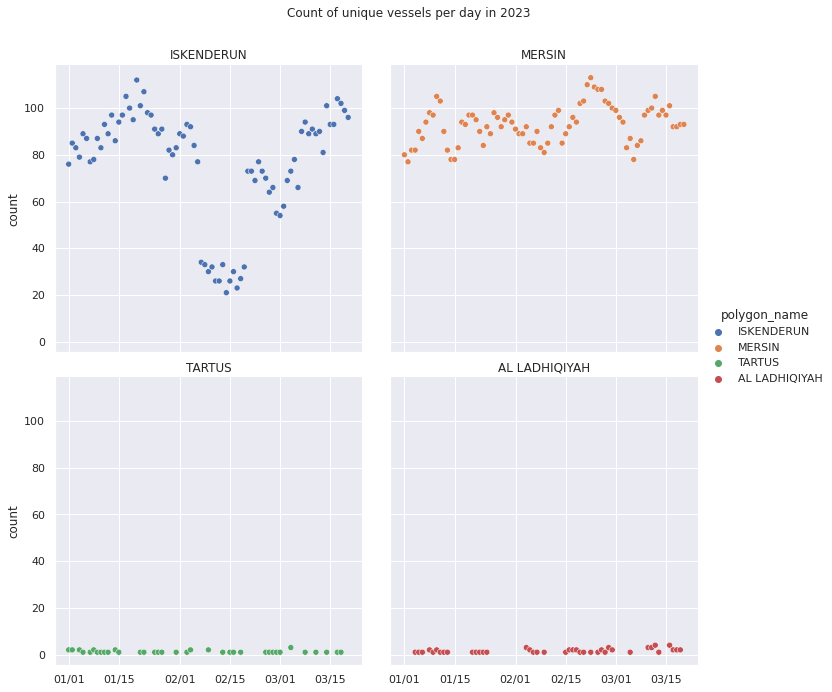

In [76]:
# fig, ax = plt.subplots(figsize=(12, 8))

g = sns.relplot(
    data=df_temp,
    x='Date',
    y='mmsi',
    hue='polygon_name',
    kind='scatter',
    col='polygon_name',
    col_wrap=2,
)

# dates = df_temp['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
xformatter = mdates.DateFormatter("%m/%d")
g.axes[0].xaxis.set_major_formatter(xformatter)
g.axes[0].set_ylabel("count")
g.axes[2].set_ylabel("count")
g.axes[2].set_xlabel("")
g.axes[3].set_xlabel("")

g.set_titles(template='{col_name}')

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Count of unique vessels per day in 2023')

Text(0.5, 0.98, 'Count of unique vessels per day in 2023')

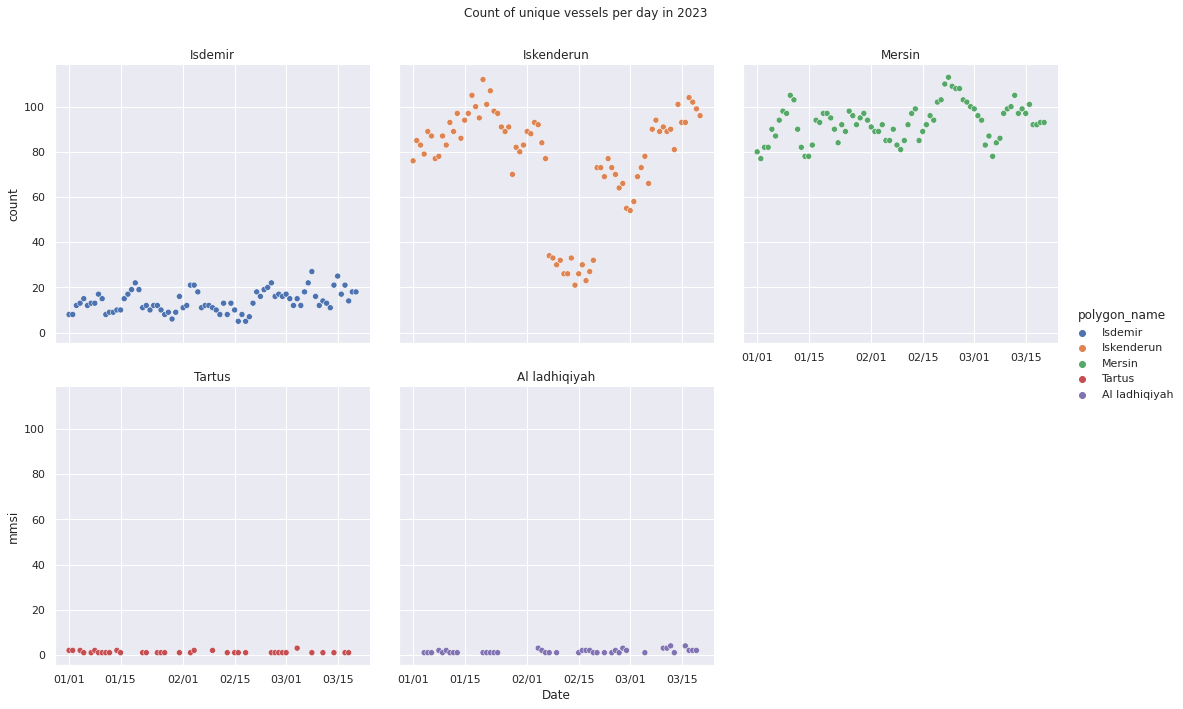

In [53]:
# fig, ax = plt.subplots(figsize=(12, 8))

g = sns.relplot(
    data=df_temp,
    x='Date',
    y='mmsi',
    hue='polygon_name',
    kind='scatter',
    col='polygon_name',
    col_wrap=3,
)

# dates = df_temp['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
xformatter = mdates.DateFormatter("%m/%d")
g.axes[0].xaxis.set_major_formatter(xformatter)
g.axes[0].set_ylabel("count")
g.axes[2].set_ylabel("count")
g.axes[2].set_xlabel("")
g.axes[3].set_xlabel("")

g.set_titles(template='{col_name}')

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Count of unique vessels per day in 2023')